Normalised Data: Class 0 - 4536, Class 1 - 12464
Non-Normalised Data: Class 0 - 12526, Class 1 - 4474


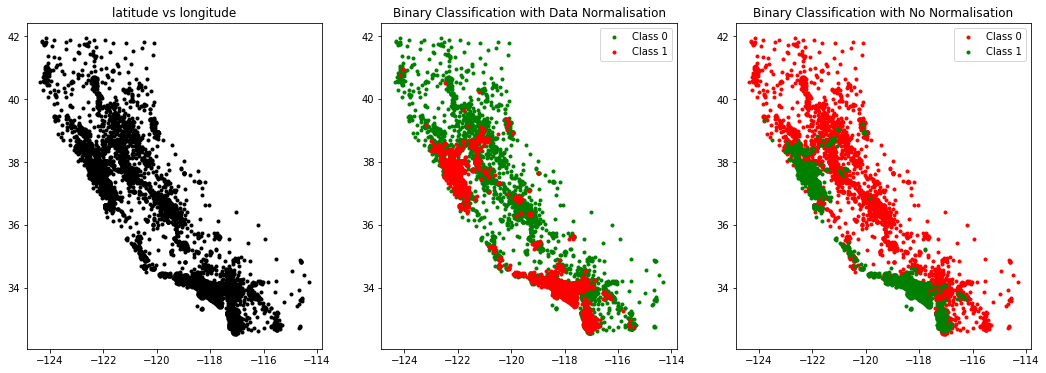

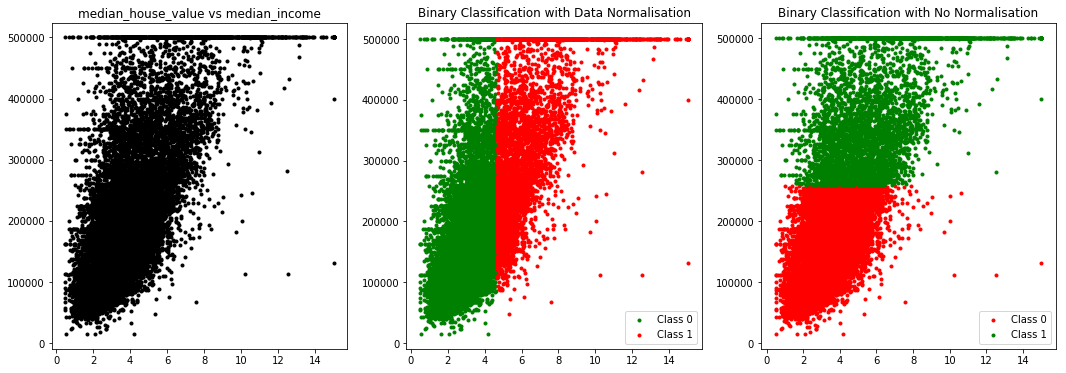

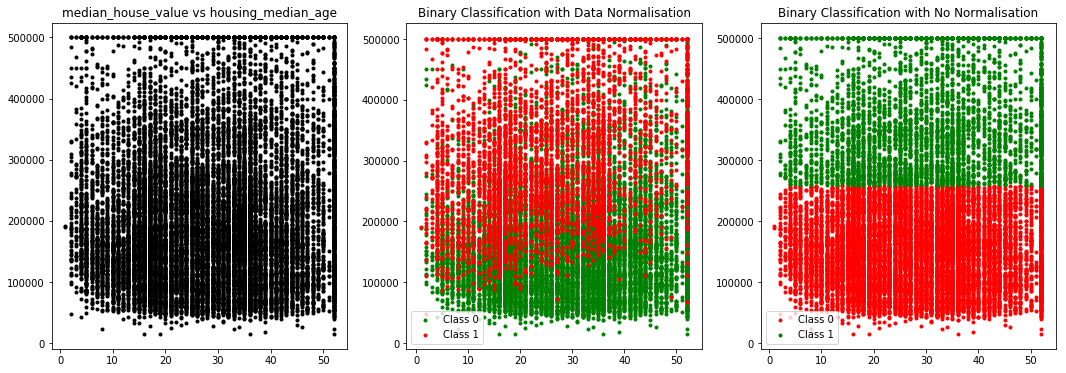

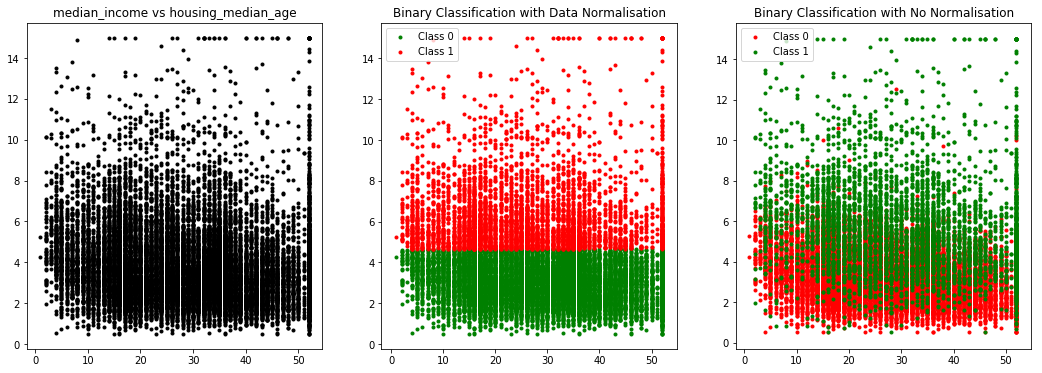

In [1]:
#Applied Kmeans to California Housing Price Data using Scikit learn
#We implement a 2 cluster classification with and without normalisation to observe
#how classification behaviour varies when normalisation is applied
#In this case, (X - mean)/variance is the normalisation formula used
#Plots of between certain features are chosen to show how each dataset was classified

#Import dependencies
import numpy as np
import pandas as pd
import sklearn as sk
import math
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Normalise the selected dataframe (Optional params like mean and variance can also be added)
def normalise_df(input_dataframe, mean = 0, variance = 0):
  i = 0
  normalised_dataframe = pd.DataFrame()
  mean_output = []
  variance_output = []

  while i != len(input_dataframe.columns):
    column_name = input_dataframe.columns[i]
    val_array = np.array(input_dataframe[column_name])
    
    if mean == 0:
      array_mean = np.mean(val_array)
      mean_output.append(array_mean)
    else:
      array_mean = mean[i]
    
    if variance == 0:
      array_var = np.var(val_array)
      variance_output.append(array_var)
    else:
      array_var = variance[i]
      
    norm_array = (val_array - array_mean)/array_var
    new_df = pd.DataFrame(pd.Series(norm_array), columns = [column_name])
    normalised_dataframe = pd.concat([normalised_dataframe, new_df], axis = 1)
    i += 1
    
  return normalised_dataframe, mean_output, variance_output

def split_labels(dataframe):
  #Split the data by their labels
  f = 0

  for i in range(len(dataframe)):
    if dataframe['labels'][i] == 0:
      f += 1

  label_0 = dataframe[0:f]
  label_1 = dataframe[f:len(dataframe)]
  
  return label_0, label_1

def kmeans_splitlabel(fitting_data, original_data, predict_data = '', prediction = 0):
  #Apply Kmeans clustering and assign label to a dataframe, concat labels with normalised dataframe
  kmeans = KMeans(n_clusters=2, random_state=0).fit(fitting_data)
  if prediction == 0:
    kmean_labels = pd.DataFrame(pd.Series(kmeans.labels_), columns = ['labels'])
  else:
    kmean_labels = pd.DataFrame(pd.Series(kmeans.predict(predict_data)), columns = ['labels'])
  labelled_df = pd.concat([original_data, kmean_labels], axis = 1)

  #Sort dataframe by labels
  sorted_df = labelled_df.sort_values('labels', ascending = True).reset_index(drop = True)
  
  label_0, label_1 = split_labels(sorted_df)
  
  return label_0, label_1

#Plot 3 graphs: 1 using the original data. 2 using the normalised data. 3 using the non-normalised data.
def plotgraphs(main_data ,x_label, y_label):
  plt.subplot(131)
  plt.title(y_label + ' vs ' + x_label)
  plt.scatter(main_data[x_label], main_data[y_label], marker='.', color = 'k')

  #This graph plots are inverted so that the colour with more points goes to the background
  plt.subplot(132)
  plt.title('Binary Classification with Data Normalisation')
  plt.scatter(label_1[x_label], label_1[y_label], marker='.', color = 'g')
  plt.scatter(label_0[x_label], label_0[y_label], marker='.', color = 'r')
  plt.legend(['Class 0', 'Class 1'])

  plt.subplot(133)
  plt.title('Binary Classification with No Normalisation')
  plt.scatter(label_0_nn[x_label], label_0_nn[y_label], marker='.', color = 'r')
  plt.scatter(label_1_nn[x_label], label_1_nn[y_label], marker='.', color = 'g')
  plt.legend(['Class 0', 'Class 1'])

#Import Data
train_data = pd.read_csv('sample_data/california_housing_train.csv')
test_data = pd.read_csv('sample_data/california_housing_test.csv')

#Removed longitude and latitude to remove possible location based clustering
X = train_data.drop(columns = ['longitude', 'latitude'])
Y = test_data.drop(columns = ['longitude', 'latitude'])

#Normalise dataset over X:training dataset only.
normalised_X, X_mean, X_variance = normalise_df(X)

#Apply kmeans and output labelled data
label_0, label_1 = kmeans_splitlabel(normalised_X, train_data)
label_0_nn, label_1_nn = kmeans_splitlabel(X, train_data)

#Plot data by labels: red for 0 and green for 1.
plt.figure(figsize=[18,6])
plotgraphs(train_data, 'longitude', 'latitude')

plt.figure(figsize=[18,6])
plotgraphs(train_data, 'median_income', 'median_house_value')

plt.figure(figsize=[18,6])
plotgraphs(train_data, 'housing_median_age', 'median_house_value')

plt.figure(figsize=[18,6])
plotgraphs(train_data, 'housing_median_age', 'median_income')

print('Normalised Data: Class 0 - {}, Class 1 - {}'.format(label_0['labels'].count(), label_1['labels'].count()))
print('Non-Normalised Data: Class 0 - {}, Class 1 - {}'.format(label_0_nn['labels'].count(), label_1_nn['labels'].count()))

Normalised Data: Class 0 - 750, Class 1 - 2250
Non-Normalised Data: Class 0 - 2224, Class 1 - 776


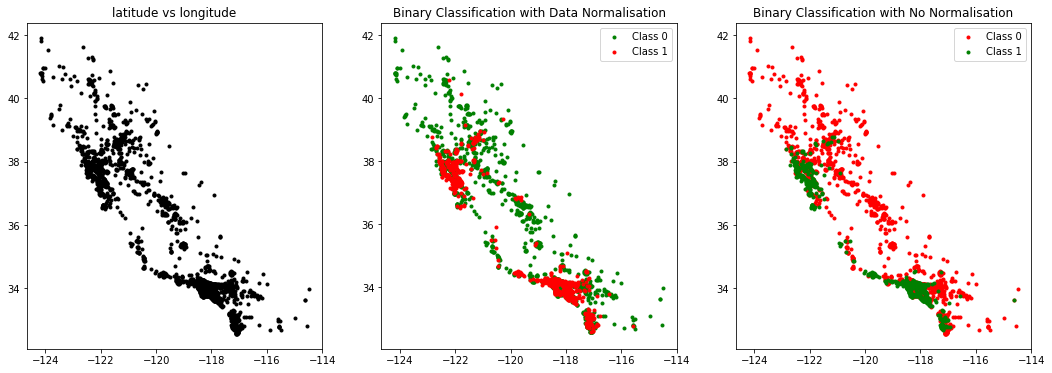

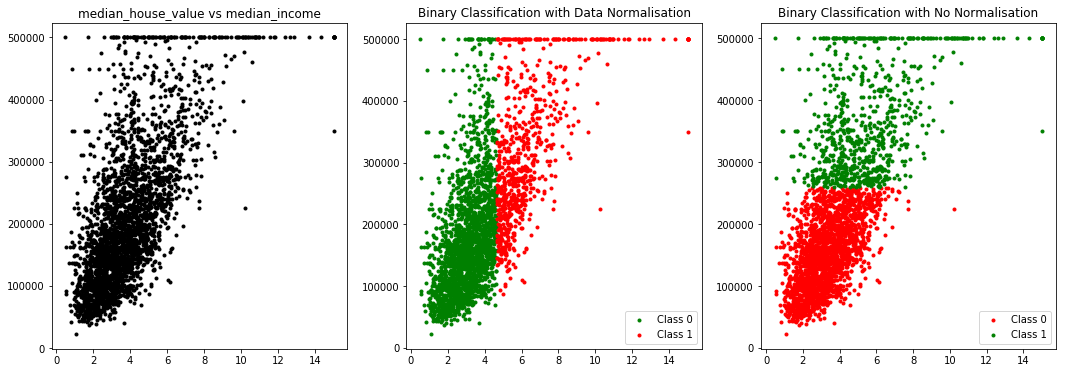

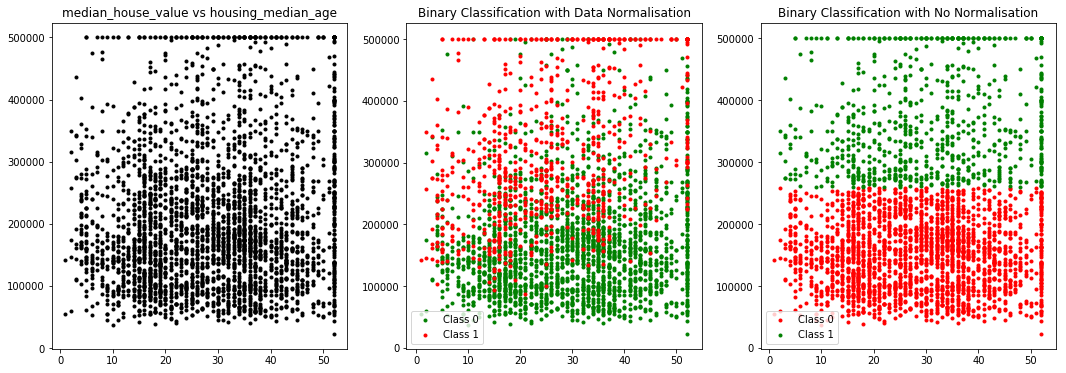

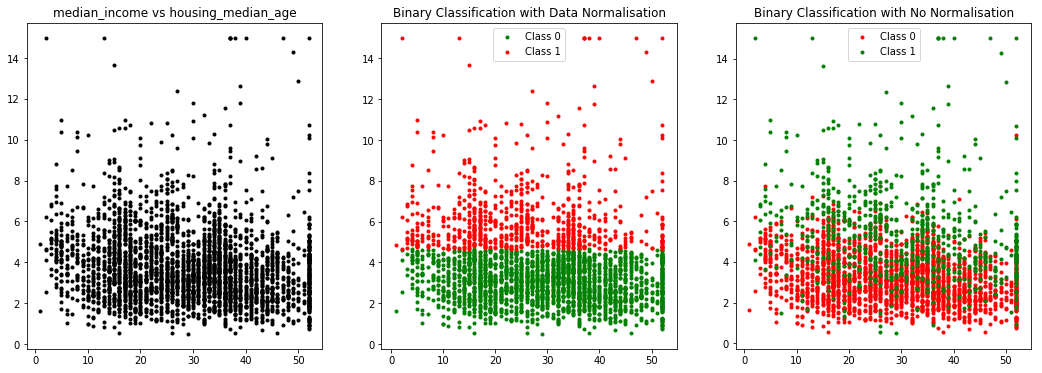

In [2]:
#In this segment we apply a inverse distance sum function to determine the probabilities of obtaining either 0 or 1
#We apply the clustering algorithm to the test data and plot the relevant graphs to 
#observe how they are distributed

#Used as a proxy for probability.
def inverse_distance(x, y):
  return (1/x)/ ((1/x)+(1/y))

#For Non-normalised Y and X
label_0_nn, label_1_nn = kmeans_splitlabel(X, test_data, Y, 1)

#Normalised Y and X
normalised_Y, _, _ = normalise_df(Y, X_mean, X_variance)
kmeans = KMeans(n_clusters=2, random_state=0).fit(normalised_X)
kmean_labels = pd.DataFrame(pd.Series(kmeans.predict(normalised_Y)), columns = ['labels'])
final_test_df = pd.concat([test_data, kmean_labels], axis = 1)

#Calculate the distance between each center and a data point
distance_Y = kmeans.transform(normalised_Y)

#Assign distances to center for each point to zero_list for 0 or one_list for 1.
zero_list = []
one_list = []
i = 0

while i != len(distance_Y):
  zero_list.append(distance_Y[i][0])
  one_list.append(distance_Y[i][1])
  i += 1

#Assign probability based on distance and append to Dataframe
probability = inverse_distance(np.array(one_list), np.array(zero_list))
probability_labels = pd.DataFrame(pd.Series(probability), columns = ['probability'])
final_test_df = pd.concat([final_test_df, probability_labels], axis = 1)

#Sort by label then Split data using labels for plotting
final_test_df = final_test_df.sort_values('labels', ascending = True).reset_index(drop = True)
label_0, label_1 = split_labels(final_test_df)

#Plot the graph: red for 0 and green for 1
plt.figure(figsize=[18,6])
plotgraphs(test_data, 'longitude', 'latitude')

plt.figure(figsize=[18,6])
plotgraphs(test_data, 'median_income', 'median_house_value')

plt.figure(figsize=[18,6])
plotgraphs(test_data, 'housing_median_age', 'median_house_value')

plt.figure(figsize=[18,6])
plotgraphs(test_data, 'housing_median_age', 'median_income')

print('Normalised Data: Class 0 - {}, Class 1 - {}'.format(label_0['labels'].count(), label_1['labels'].count()))
print('Non-Normalised Data: Class 0 - {}, Class 1 - {}'.format(label_0_nn['labels'].count(), label_1_nn['labels'].count()))

In [3]:
final_test_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,labels,probability
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0,0,0.073506
1,-117.84,33.89,24.0,3935.0,625.0,1912.0,593.0,5.7951,226900.0,0,0.158994
2,-117.04,32.62,26.0,3620.0,607.0,2000.0,593.0,4.9962,156000.0,0,0.398605
3,-122.48,37.71,29.0,1048.0,150.0,455.0,152.0,6.1278,417600.0,0,0.062311
4,-122.59,38.12,25.0,7784.0,1145.0,3445.0,1166.0,6.0132,287900.0,0,0.093459
5,-118.33,34.06,52.0,1368.0,231.0,737.0,248.0,8.3617,433800.0,0,0.282766
6,-121.87,37.27,25.0,1730.0,226.0,721.0,243.0,7.5845,279300.0,0,0.215627
7,-122.69,38.46,32.0,2970.0,504.0,1117.0,512.0,5.0000,275900.0,0,0.398907
8,-118.86,34.07,16.0,1409.0,244.0,970.0,172.0,8.0144,500001.0,0,0.253416
9,-118.11,33.86,36.0,2750.0,487.0,1386.0,458.0,4.9904,221700.0,0,0.403480
